## Enumeration of pathway models

This notebook demonstrates the steps for predicting the pathway involving the enzymes encoded by a gene cluster from Haemophilus influenzae.

### 1) Import libraries

In [3]:
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import numpy as np
from tables import open_file
import pickle

from pathway_restraints import sea_restraint, dock_restraint, cmetab_restraint, tfluor_restraint, evidence_restraint, dataTables
from sample_graph import Paths
sys.path.append('/trombone1/home/scalhoun/pathway')
from reaction_calculations import ligandData
import pathway_analysis as pa
import backtracking as bt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 2) Assign filenames and reactions

In [4]:
#############################################################
# INPUT FILENAMES
#
ligandfile = 'pathway_example/gul_candidate_ligands.txt'
seafile = 'pathway_example/sea_condensed.csv'
thermofluor = 'pathway_example/thermofluor_hits.txt'
cmetabfile = 'pathway_example/central_metab.smi'
evidencefile = 'pathway_example/dehydratase_substrate.txt'

dockfiles = {'0':'pathway_example/docking_scores/combine.scores.C9MHP2',
             '1':'pathway_example/docking_scores/combine.scores.C9MHP1',
             '2':'pathway_example/docking_scores/combine.scores.C9MHP6',
             '3':'pathway_example/docking_scores/combine.scores.C9MHN9',
             '4':'pathway_example/docking_scores/combine.scores.C9MHP5',
             '5':'pathway_example/docking_scores/combine.scores.C9MHP7'}

#############################################################
# OUTPUT FILENAMES
datafile = 'pathway_example/gul_data.h5'
pfile = 'pathway_example/soln.pickle'
h5out = 'pathway_example/solutions.h5'



kinase=['[C:1][O:2][H]>>[C:1][O:2][P](O)(O)=O',
        '[C:1][O:2][P](O)(O)=O>>[C:1][O:2][H]']
dehydratase=['[H][O:1][C:2]([H])[C:3]([H])[O][H]>>[O:1]=[C:2][C:3]([H])[H]',
             '[O:1]=[C:2][C:3]([H])[H]>>[H][O:1][C:2]([H])[C:3]([H])[O][H]']
aldolase=['[A:1][C:2][C:3]([O:4][H])[A:5]>>[A:1][C:2][H].[O:4]=[C:3][A:5]']
dehydrogenase=['[H][O:1][C:2]([H])([A:3])[A:4]>>[O:1]=[C:2]([A:3])([A:4])',
               '[O:1]=[C:2]([A:3])([A:4])>>[H][O:1][C:2]([H])([A:3])[A:4]']
reductase=['[O:1]=[C:2]([A:3])([A:4])>>[H][O:1][C:2]([H])([A:3])[A:4]',
           '[H][O:1][C:2]([H])([A:3])[A:4]>>[O:1]=[C:2]([A:3])([A:4])']

reactions = {'1': dehydrogenase, 
             '2': reductase, 
             '3': dehydratase,
             '4': kinase, 
             '5': aldolase}

enzymes = reactions.keys()
proteins = dockfiles.keys()

### 3) Compute and save combined data file

In [3]:
lig = ligandData(datafile=datafile, smilesfile=ligandfile)
lig.save_smiles()
lig.save_docking_scores(dockfiles, id_column=1, score_column=7)
lig.save_sea_scores(seafile, proteinlist=proteins)
lig.save_thermofluor_scores(thermofluor)
lig.save_evidence_scores({'3':evidencefile})
lig.save_central_metabolism_endpt_scores(cmetabfile)

Number of molecules: 3650
Docking scores saved
Sea scores saved
Thermofluor scores saved
Evidence scores saved
Central metabolism scores saved


### 4) Compute reaction sets and write to file
Note, this step can take a couple of hours

In [9]:
lig.save_reaction_sets(reactions)

1
 [H][O:1][C:2]([H])([A:3])[A:4]>>[O:1]=[C:2]([A:3])([A:4])
 [O:1]=[C:2]([A:3])([A:4])>>[H][O:1][C:2]([H])([A:3])[A:4]
3
 [H][O:1][C:2]([H])[C:3]([H])[O][H]>>[O:1]=[C:2][C:3]([H])[H]
 [O:1]=[C:2][C:3]([H])[H]>>[H][O:1][C:2]([H])[C:3]([H])[O][H]
2
 [O:1]=[C:2]([A:3])([A:4])>>[H][O:1][C:2]([H])([A:3])[A:4]
 [H][O:1][C:2]([H])([A:3])[A:4]>>[O:1]=[C:2]([A:3])([A:4])
5
 [A:1][C:2][C:3]([O:4][H])[A:5]>>[A:1][C:2][H].[O:4]=[C:3][A:5]
4
 [C:1][O:2][H]>>[C:1][O:2][P](O)(O)=O
 [C:1][O:2][P](O)(O)=O>>[C:1][O:2][H]
Reaction sets saved


### 5) Read in computed reaction sets, enumerate all possible pathways, and write to a pickle file

In [4]:
rxns = bt.read_in_reactions_df(datafile)
bt.enumerate_pathways(rxns, len(enzymes), pfile)

Number of solutions: 29353
Number of solutions: 122537
Number of solutions: 203964
Number of solutions: 99552
Writing 99552 pathway solutions to soln.pickle


### 6) Read in possible pathways, and score pathways

In [5]:
solution_list = pickle.load(open(pfile, 'r'))

d = dataTables()
d.readInLigands(ligandfile)
d.readInSelectedTables(datafile, ['dock', 'sea', 'cmetab', 'tfluor', 'evid'])

with open_file(h5out, 'w') as h5outhandle:
    ps = Paths(d, h5outhandle)
    sr = sea_restraint()
    dr = dock_restraint()
    cr = cmetab_restraint()
    tr = tfluor_restraint()
    er = evidence_restraint()
    
    restraints = [sr, dr, cr, tr, er]
    restraints = [dr, cr, tr, er]
    ps.score_solutions(solution_list, restraints, transporter='0')
    

3650 ligands from pathway_example/gul_candidate_ligands.txt
Best Observed: 0 -> ZINC03869787 -> 1 -> ZINC04095492 -> 2 -> ZINC02040884 -> 3 -> ZINC01532568 -> 4 -> ZINC01529165 -> 5 -> ZINC03869936
docking score: 0.156
central metab endpoint score: 5.082
thermofluor score: 8.066
homology evidence score: 10.078
OBJ: 23.383


### Get statistics from random sampling of pathways

### 7) Load in scored pathways and filter down to good-scoring pathways

In [6]:
pathar = pa.load_pathway_scores(h5out)
ps.data.proteins = enzymes
goodsolns = ps.filter_solutions_by_stats(pathar, 100000, restraints, transporter='0')

99552 paths filtered down to 24 within 1.0 standard deviation(s)


### 8) Plot distribution of scores

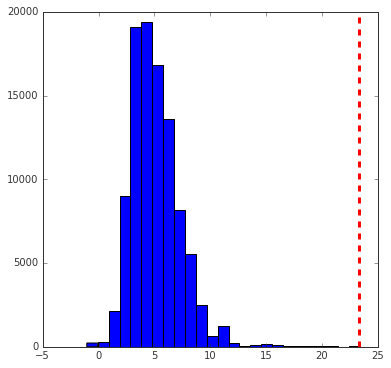

In [6]:
#st = np.std(pathar['obj'])
#cu = maxscore - st

maxscore = np.max(pathar['obj'])
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.hist(pathar['obj'], bins=25)
#ax.axvline(cu, color='red', ls='--', lw=4)
ax.axvline(maxscore, color='red', ls='--', lw=3)
plt.show()

### 9) Cluster good-scoring pathways

In [7]:
gclusters, repr_cluster_dict = pa.cluster_pathways(goodsolns, threshold=0.1)

24 paths clustered into 10 groups


### 10) Visualize pathways

In [8]:
from IPython.display import display
from IPython.display import Image
import graph_drawing as gd

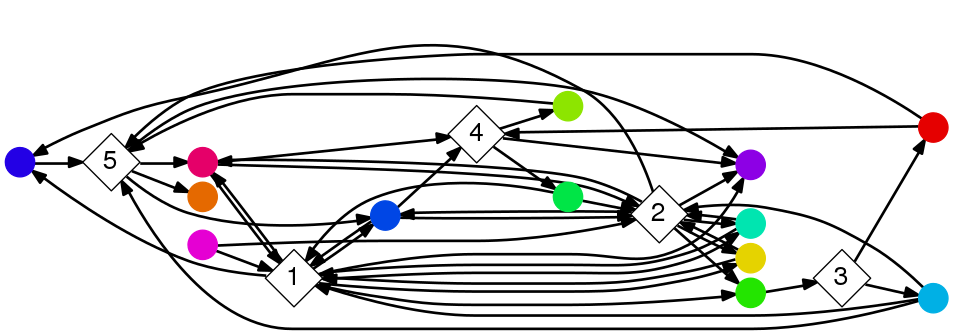

In [9]:
R = [r.strip('0 -> ') for r in goodsolns['strrepr']]
imgfile = 'pathway_example/gulnet.png'
colors = gd.make_graph_img_net_single(R, imgfile, fontsize=20, circlelabels=False, diamondlabels=True, directed=True)
Image(imgfile)


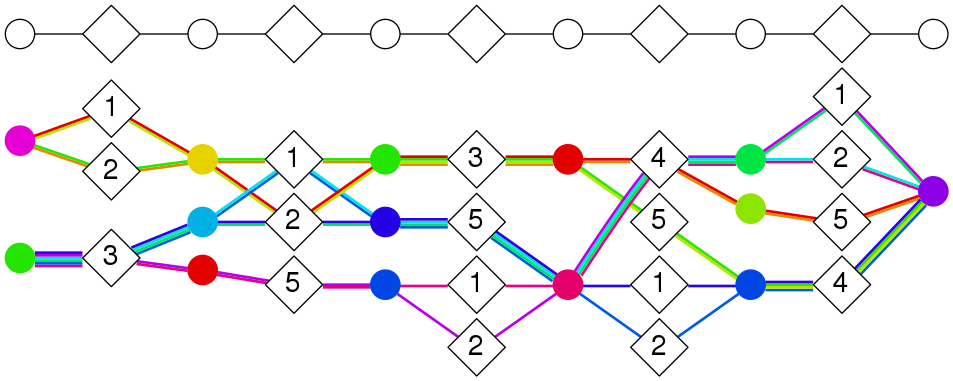

In [10]:
R = [r.strip('0 -> ') for r in reprcl.values()]
imgfile = 'pathway_example/gulpathways.png'
gd.make_graph_img(R, imgfile, nodecolordict=colors, skeleton=True)
Image(imgfile)

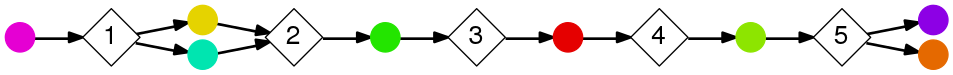

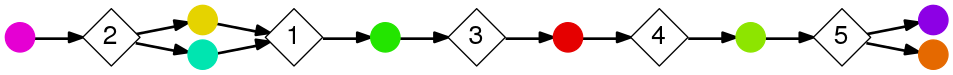

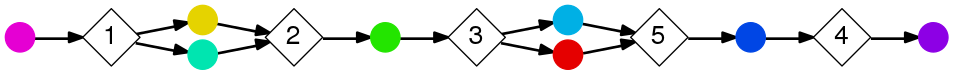

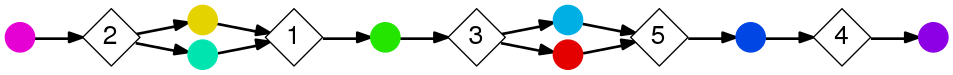

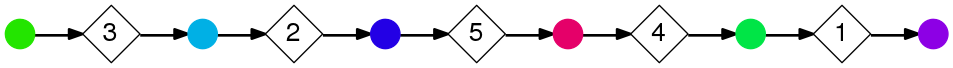

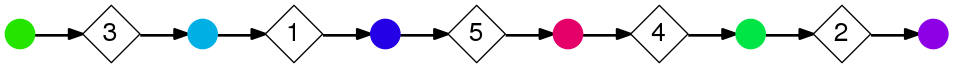

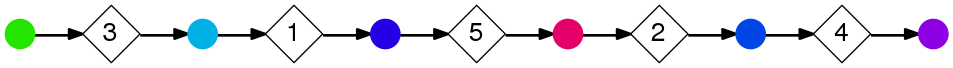

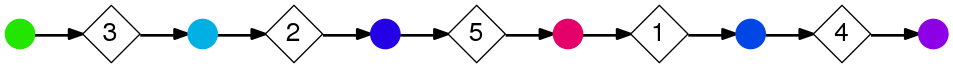

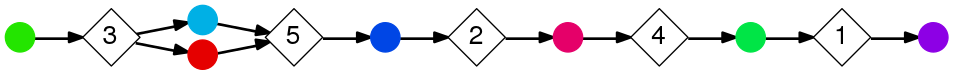

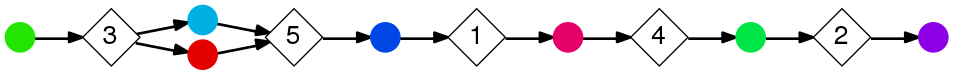

In [11]:
for k in gclusters.keys():
    imgfile = 'pathway_example/gul_%d.png' % k
    R = [r.strip('0 -> ') for r in gclusters[k]]
    gd.make_graph_img_net_single(R, imgfile, nodecolordict=colors, fontsize=20, directed=True)
    img = Image(imgfile)
    display(img)

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from PIL import ImageFont, ImageDraw, Image
from IPython.display import display
import pandas as pd

font = ImageFont.truetype('/trombone1/home/scalhoun/pics/helvetica.ttf', 16)
lilfont = ImageFont.truetype('/trombone1/home/scalhoun/pics/helvetica.ttf', 12)
black=(0, 0, 0)
gray = (45, 45, 45)
arrow_width = 10
arrow_height = 5
arrow_length = 40
arrow_space = 5
fontsize = 30

def draw_pathway(pathsol, enzymes):
    smilesdf = pd.read_hdf(datafile, 'smiles')
    molsize = (250, 150)
    pathlist = pathsol.split(' -> ')

    max_height = molsize[1]
    max_x = int((2*arrow_length + 80 + molsize[0])*len(pathlist)/2)-40
    max_y = max_height + 40
    canvas = Image.new('RGB', (max_x, max_y), 'white')

    draw = ImageDraw.Draw(canvas)
    canvaswidth = canvas.size[0]
    y = canvas.size[1]/2
    curr = 10

    for p in range(len(pathlist)):
        node = pathlist[p]
        
        # Draw enzyme node
        if node in enzymes:
            draw.polygon([(curr, y), (curr+25, int(y+25)), (curr+50, y),
                          (curr+25, int(y-25))],
                          fill=(255, 255, 255), outline=gray)
            draw.text((10+10+curr, int(y-0.3*fontsize)), node, (0, 0, 0), font=font)

            curr += 50
        # Draw ligand node
        else:
            smi = smilesdf.get_value(node)
            mol = Chem.MolFromSmiles(smi)
            AllChem.Compute2DCoords(mol)
            img = Draw.MolToImage(mol, size=(200,100))

            xy = (curr, (max_y-100)/2)
            canvas.paste(img, box=xy)
            draw.text((curr+10, y+50), node, black, font=lilfont)
            curr += 200
        # Draw arrow
        if p+1 < len(pathlist):
            endline = curr+arrow_length
            draw.line([(arrow_space+curr, y), (endline, y)], fill=black, width=2)
            draw.polygon([(endline-arrow_width, y-arrow_height), 
                          (endline-arrow_width, y+arrow_height),
                          (endline, y)], 
                          fill=black)
            curr += arrow_length + arrow_space

    return canvas

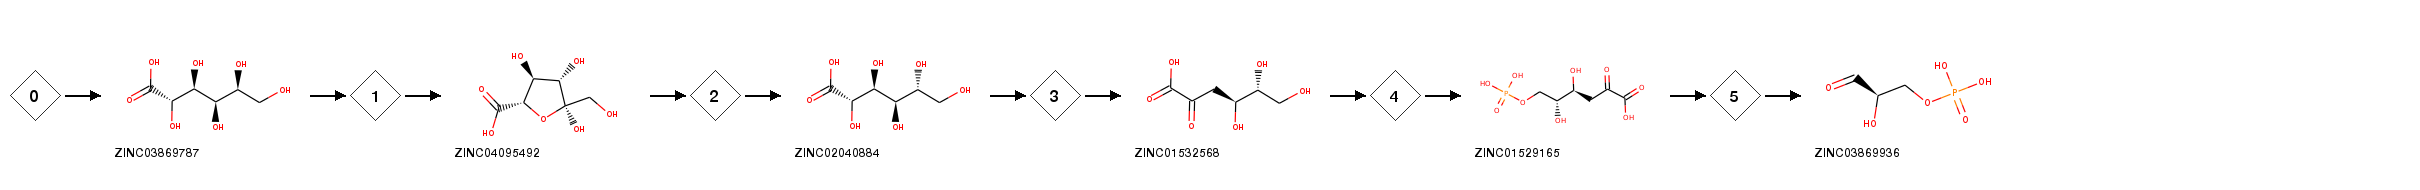

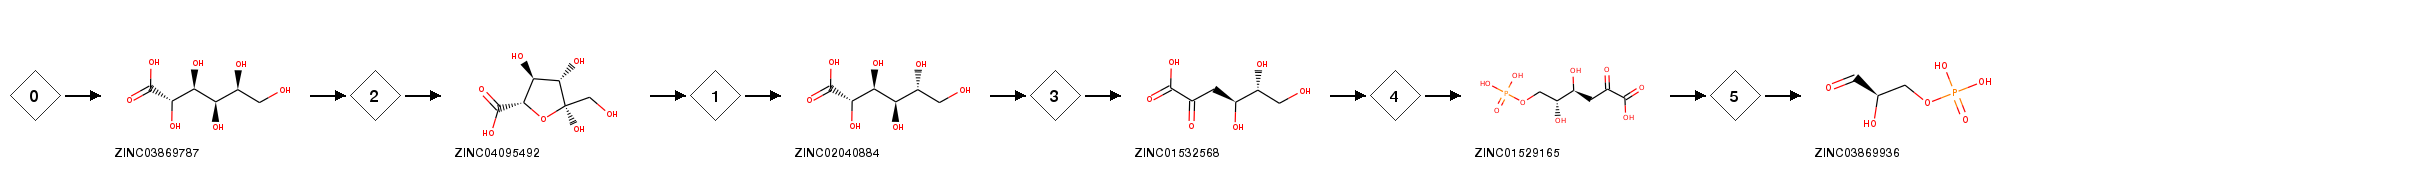

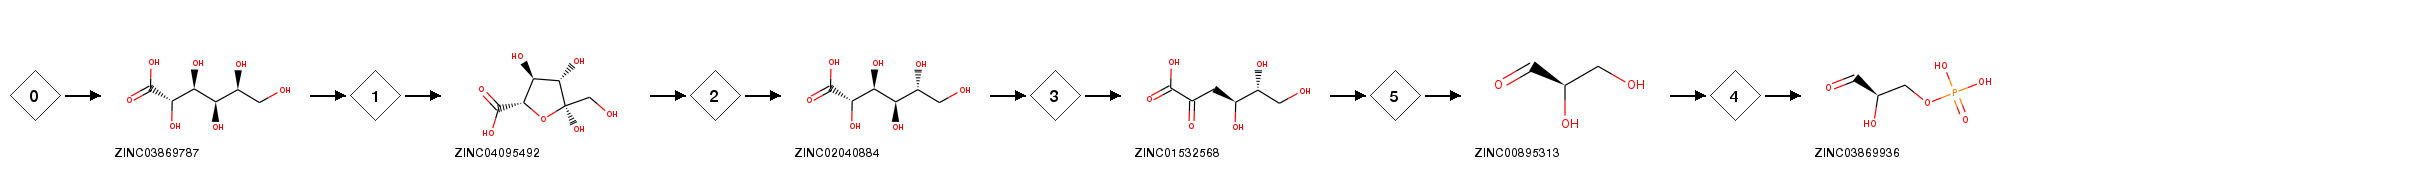

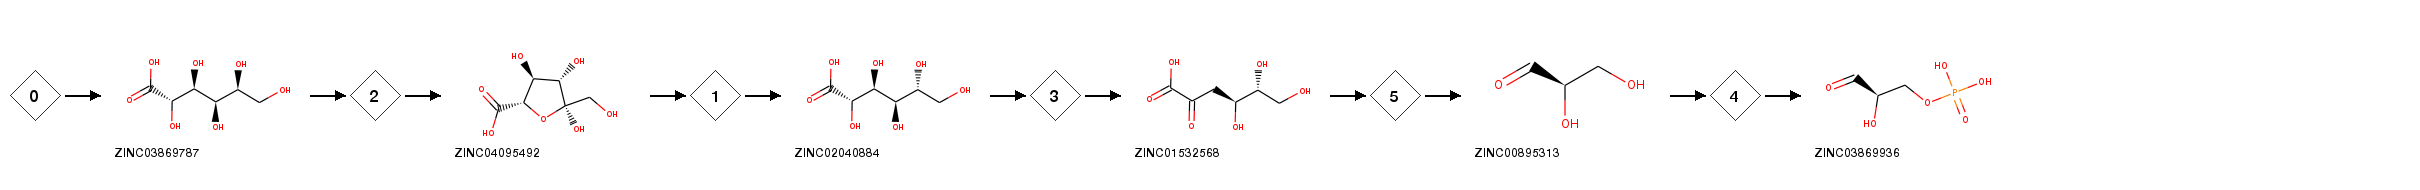

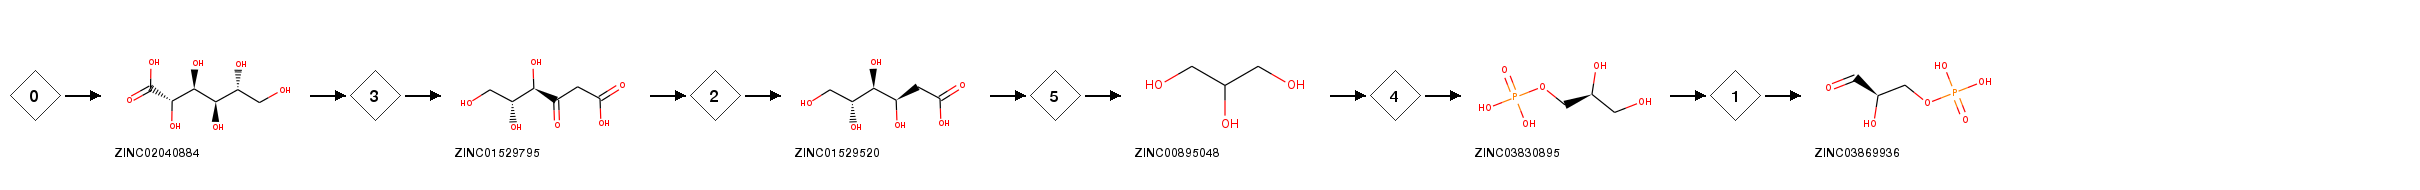

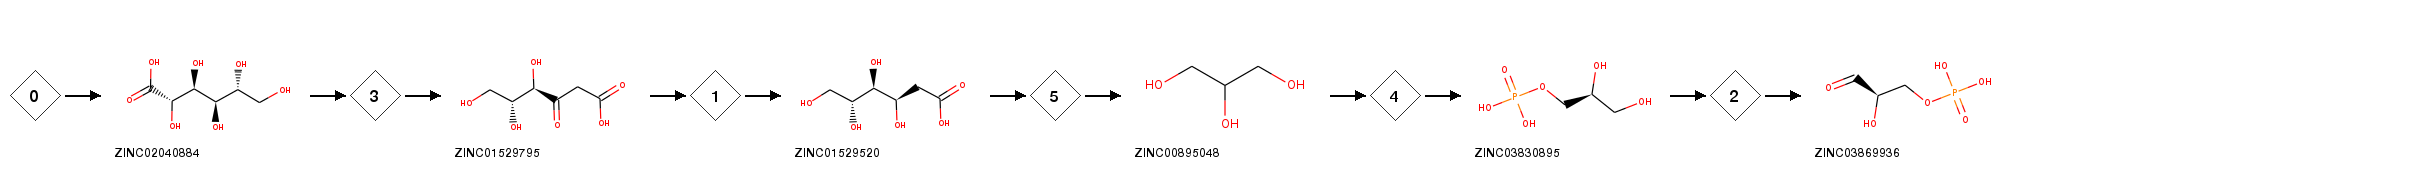

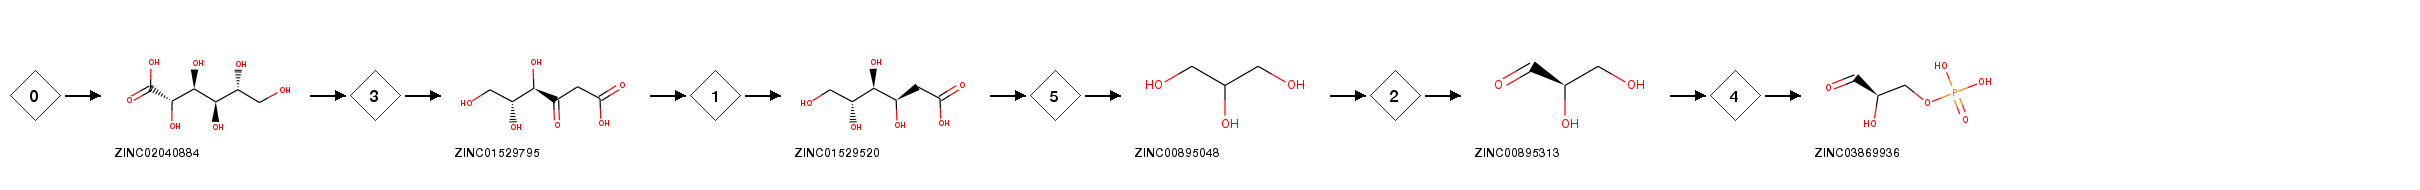

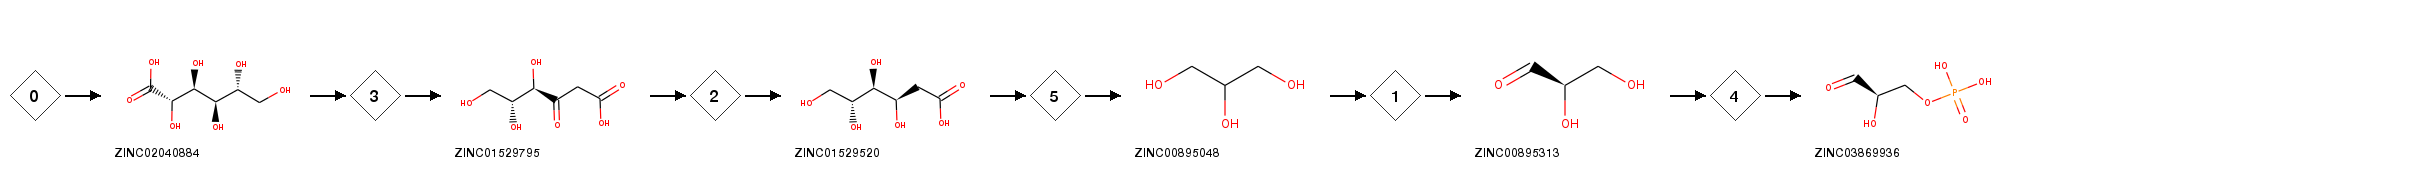

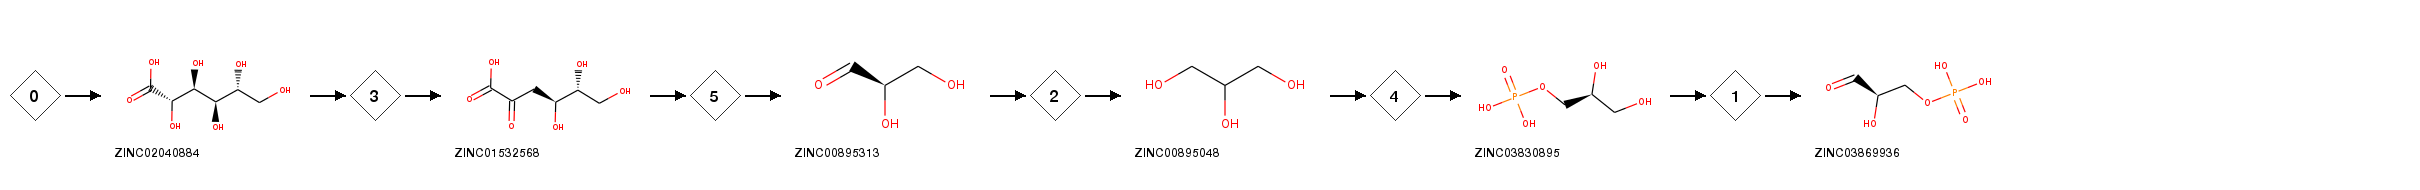

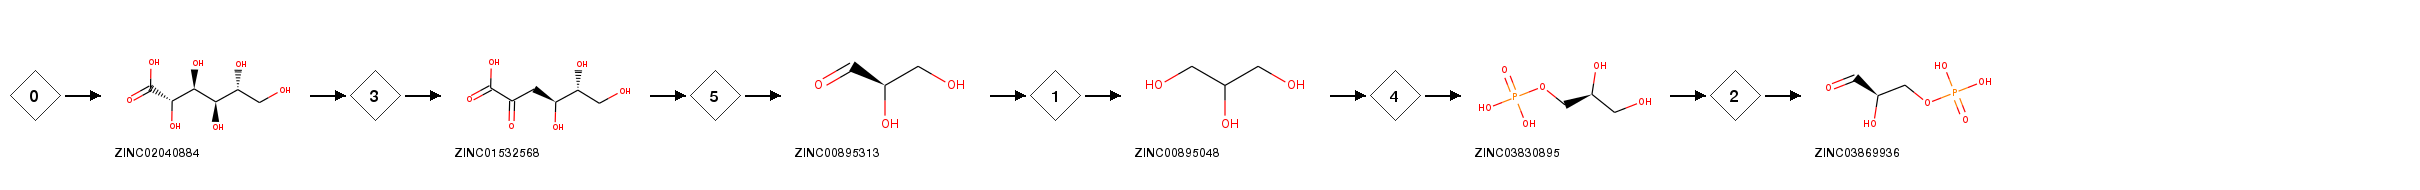

In [9]:

for k in repr_cluster_dict.keys():
    repr_pathway = repr_cluster_dict[k]
    c = draw_pathway(repr_pathway, proteins)
    display(c)
    #c.save('pathway_example/enumerate_cluster_%s.png' % k)